# Poisson equation (horizontal case)
**21 December 2020 by MiniUFO**

---
[TOC]

---

## 1. Introduction
One of the classical inversion problem is to solve for a streamfunction $\psi$ given the vertical component of vorticity $\zeta$ and proper boundary conditions:

$$
\begin{align}
\nabla^2 \psi = \frac{\partial^2 \psi}{\partial x^2} +\frac{\partial^2 \psi}{\partial y^2} =\zeta \notag
\end{align}
$$

This is the form in cartesian coordinates.  In spherical coordinates ($\lambda$, $\phi$, $z$), it is written as:

$$
\begin{align}
\nabla^2 \psi = \frac{1}{r^2}\frac{\partial^2 \psi}{a^2\partial \lambda^2} +\frac{1}{r}\frac{\partial}{a\partial\phi}\left(r\frac{\partial \psi}{a\partial \phi}\right) =\zeta \notag
\end{align}
$$

where $r=\cos\phi$.  Note that this should be modified slightly to fit the solver as:

$$
\begin{align}
\frac{\partial}{a\partial \lambda}\left(\frac{1}{r}\frac{\partial \psi}{a\partial \lambda}\right) +\frac{\partial}{a\partial \phi}\left(r\frac{\partial \psi}{a\partial \phi}\right) =r\zeta \notag
\end{align}
$$

---
## 2. Example: Helmholtz decomposition
This is a classical problem in both meteorology and oceanography that a vector flow field can be deomposed into rotational and divergent parts (known as [Helmholtz decomposition](https://en.wikipedia.org/wiki/Helmholtz_decomposition)), where rotational and divergent parts are represented by the streamfunction $\psi$ and velocity potential $\chi$ as:

$$
\begin{align}
\frac{\partial^2 \psi}{\partial x^2} +\frac{\partial^2 \psi}{\partial y^2} &=\frac{\partial v}{\partial x} -\frac{\partial u}{\partial y}=\zeta\tag{1}\\
\frac{\partial^2 \chi}{\partial x^2} +\frac{\partial^2 \chi}{\partial y^2} &=\frac{\partial u}{\partial x} +\frac{\partial v}{\partial y}=\eta\tag{2}
\end{align}
$$

Given vorticity ($\zeta$) and divergence ($\eta$) as the forcing functions respectively in Eqs. (1) and (2) (i.e., two Poisson equations), one can invert the streamfunction $\psi$ and velocity potential $\chi$ using [SOR](https://mathworld.wolfram.com/SuccessiveOverrelaxationMethod.html) iteration method.


### 2.1 Atmospheric demonstration
Here is an atmospheric demonstration with no lateral boundaries.  First, we load in vorticity data from a file:

In [1]:
import sys
import xarray as xr
sys.path.append('../../../')

ds  = xr.open_dataset('../../../Data/Helmholtz_atmos.nc')
vor = ds.vor

print(ds)

<xarray.Dataset>
Dimensions:  (time: 2, lat: 73, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 2008-01-02
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    u        (time, lat, lon) float32 ...
    v        (time, lat, lon) float32 ...
    div      (time, lat, lon) float32 ...
    vor      (time, lat, lon) float32 ...
    sf       (time, lat, lon) float32 ...
    vp       (time, lat, lon) float32 ...
Attributes:
    comment:  uwnd anomaly
    storage:  99
    title:    plumb_flux
    undef:    99999.0
    pdef:     None


Inverting the streamfunction, within lat/lon plane but loop over time dimension, is as simple as:

In [2]:
from xinvert import invert_Poisson

iParams = {
    'BCs'      : ['extend', 'periodic'],
    'mxLoop'   : 1000,
    'tolerance': 1e-12,
}

sf = invert_Poisson(vor, dims=['lat','lon'], iParams=iParams)

{time: 2008-01-01T00:00:00} loops 1000 and tolerance is 5.164704e-09
{time: 2008-01-02T00:00:00} loops 1000 and tolerance is 6.395749e-09


Notice that this is a global case, so the zonal boundary condition is periodic.  Meridional extend boundary condition allows streamfunction to variate near the poles.  The result can be visualized as:

C:\ProgramData\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\ProgramData\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\ProgramData\anaconda3\lib\site-packages\cartopy\crs.py:529: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


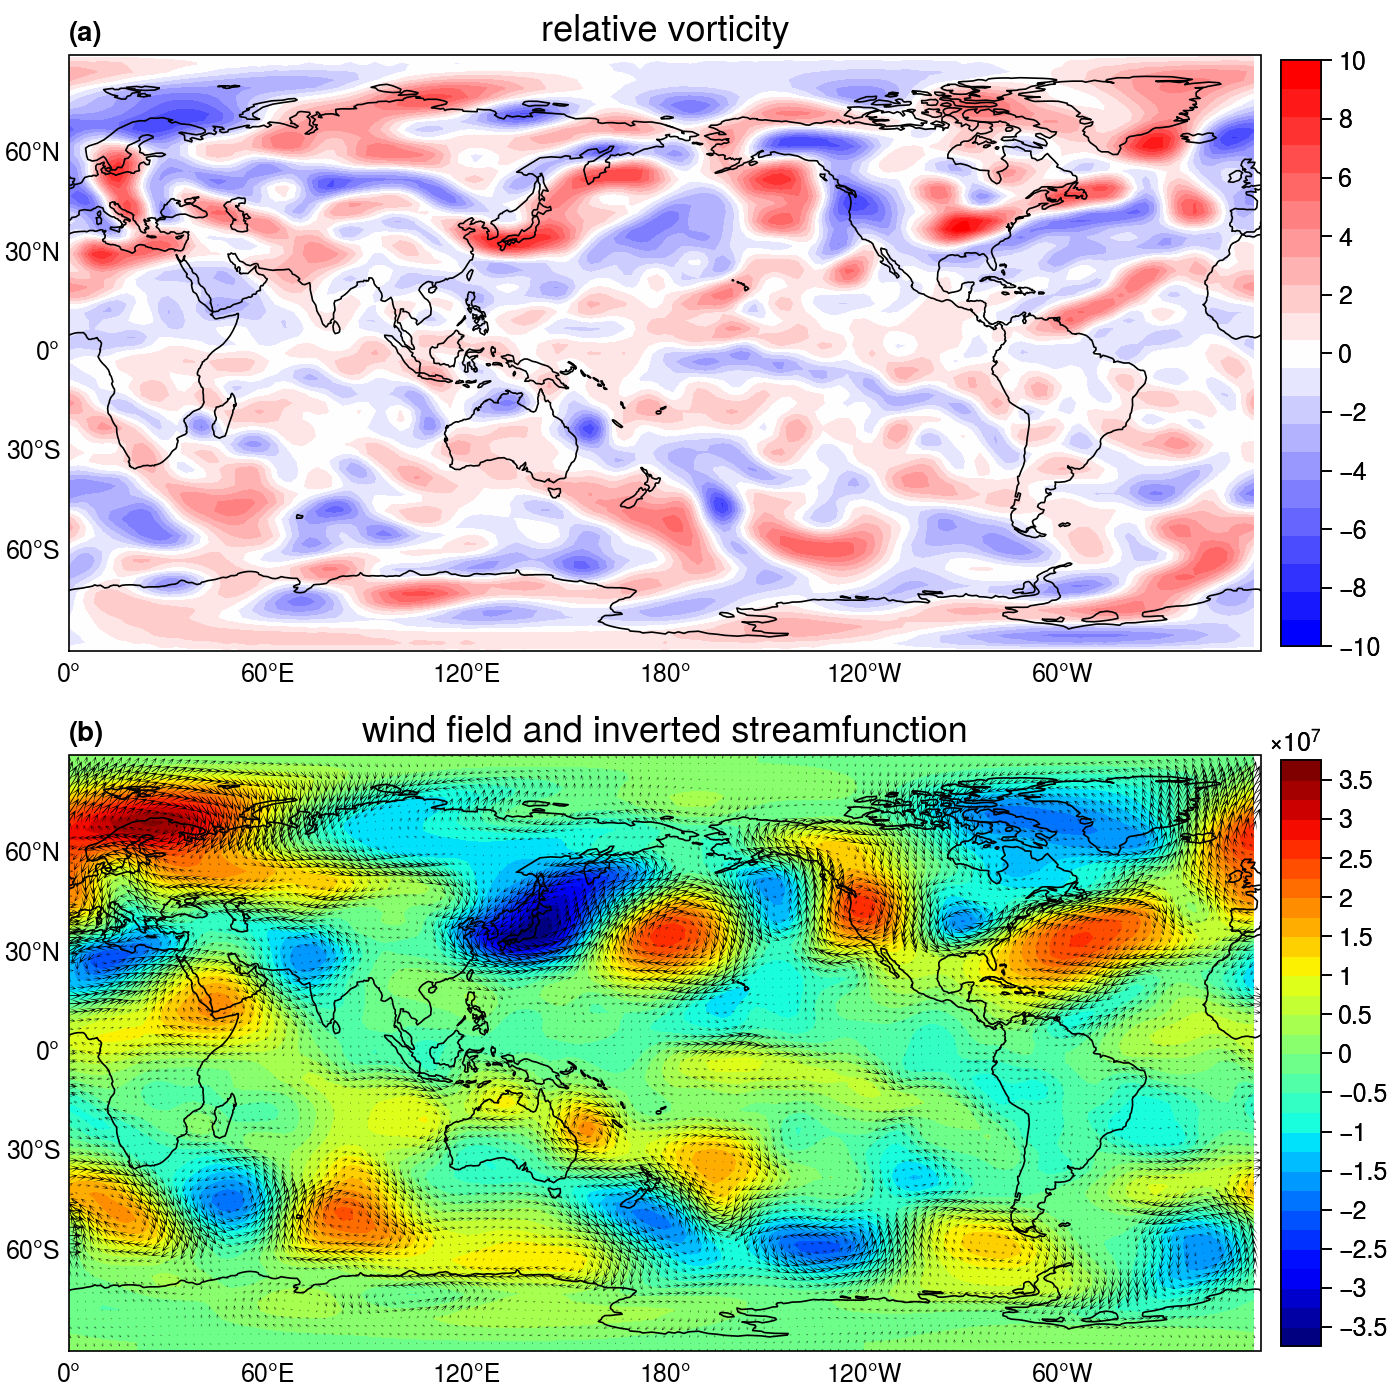

In [3]:
import proplot as pplt
import xarray as xr
import numpy as np

# select the first time step
u = ds.u.where(ds.u!=0)[0].load()
v = ds.v.where(ds.v!=0)[0].load()
m = np.hypot(u, v)

fig, axes = pplt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=3, sharey=3,
                          proj=pplt.Proj('cyl', lon_0=180))

fontsize = 13

axes.format(abc='(a)', coast=True,
            lonlines=60, latlines=30, lonlabels='b', latlabels='l',
            grid=False, labels=False)

ax = axes[0]
p = ax.contourf(u.lon, u.lat, vor[0]*1e5, cmap='bwr',
                levels=np.linspace(-10, 10, 22))
ax.set_title('relative vorticity', fontsize=fontsize)
ax.colorbar(p, loc='r', label='', ticks=2, length=0.98)

ax = axes[1]
p = ax.contourf(u.lon, u.lat, sf[0], levels=30, cmap='jet')
ax.quiver(u.lon.values, u.lat.values, u.values, v.values,
              width=0.0007, headwidth=12., headlength=15.)
              # headwidth=1, headlength=3, width=0.002)
ax.set_title('wind field and inverted streamfunction', fontsize=fontsize)
ax.colorbar(p, loc='r', label='', length=0.98)

### 2.2 Oceanic demonstration
Here is a oceanic demonstration with complex lateral boundaries of land/sea.  Read in data from MITgcm model output and then invert similarly as:

In [4]:
import xarray as xr
import sys
sys.path.append('../../../')
from xinvert import invert_Poisson

ds = xr.open_dataset('../../../Data/Helmholtz_ocean.nc')
print(ds)

vor = ds.vor

iParams = {
    'BCs'      : ['extend', 'periodic'],
    'mxLoop'   : 1000,
    'tolerance': 1e-12,
    'undef'    : 0,
}

sf = invert_Poisson(vor, dims=['YG','XG'], coords='lat-lon', iParams=iParams)

<xarray.Dataset>
Dimensions:  (XG: 1440, time: 1, YG: 720, YC: 720, XC: 1440)
Coordinates:
  * XG       (XG) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    iter     (time) int32 ...
  * time     (time) timedelta64[ns] 00:00:00
  * YG       (YG) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * YC       (YC) float32 -89.75 -89.5 -89.25 -89.0 ... 89.25 89.5 89.75 90.0
  * XC       (XC) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    vor      (time, YG, XG) float32 ...
    UVEL     (time, YC, XG) float32 ...
    VVEL     (time, YG, XC) float32 ...
{time: 0,ns} loops 1000 and tolerance is 3.759652e-06


The result can be visualized as:

In [ ]:
import proplot as pplt
import xarray as xr
import numpy as np

# deal with staggered velocity data
u = ds.UVEL[0]
v = ds.VVEL[0].rename({'YG':'YC', 'XC':'XG'}).interp_like(u)
m = np.hypot(u, v)

fig, axes = pplt.subplots(nrows=2, ncols=1, figsize=(14, 11.6), sharex=3, sharey=3,
                          proj=pplt.Proj('cyl', lon_0=180), facecolor='w')

fontsize = 13

u = u.where(u!=0)
v = v.where(v!=0)
sf = sf.where(sf!=0)

axes.format(abc='(a)', coast=True, lonlines=60, latlines=30,
            lonlabels='b', latlabels='l', grid=False, labels=False)

ax = axes[0]
p = ax.contourf(u.XG, u.YC, vor.where(vor!=0)[0]*1e5, cmap='bwr',
                  levels=np.linspace(-5, 5, 20))
ax.set_title('relative vorticity', fontsize=fontsize)
ax.set_ylim([-66, 78])
ax.set_xlim([-180, 180])
ax.colorbar(p, loc='r', label='', ticks=1)

ax = axes[1]
skip = 2
p = ax.contourf(u.XG, u.YC, sf[0]/1e5, levels=31, cmap='jet')
ax.quiver(u.XG.values[::skip], u.YC.values[::skip],
              u.values[::skip,::skip], v.values[::skip,::skip],
              width=0.0006, headwidth=12., headlength=15.)
ax.set_title('current vector and inverted streamfunction', fontsize=fontsize)
ax.set_ylim([-66, 78])
ax.set_xlim([-180, 180])
ax.colorbar(p, loc='r', label='', ticks=0.5)
fig.savefig('/mnt/e/fig3.pdf', format='pdf', bbox_inches='tight')

/home/qianyk/miniconda3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/qianyk/miniconda3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


### 3.3 Animate the convergence of iteration
It is interesting to see the whole convergence process of SOR iteration as:

In [6]:
from xinvert import animate_iteration

ds = xr.open_dataset('../../../Data/Helmholtz_atmos.nc')

vor = ds.vor[0]
div = ds.div[0]

iParams = {'BCs': ['extend', 'periodic']}

sf = animate_iteration('Poisson', vor, dims=['lat','lon'], iParams=iParams, loop_per_frame=1, max_frames=40)
vp = animate_iteration('Poisson', div, dims=['lat','lon'], iParams=iParams, loop_per_frame=1, max_frames=40)

print(sf)

<xarray.DataArray 'inverted' (iter: 40, lat: 73, lon: 144)>
array([[[       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [   69503.73  ,    68698.43  ,    67461.984 , ...,
           146452.22  ,   146202.19  ,   145397.86  ],
        [  339279.97  ,   330957.7   ,   320265.03  , ...,
           666220.5   ,   657323.8   ,   644346.1   ],
        ...,
        [ -273618.16  ,  -302352.66  ,  -327736.9   , ...,
          -460758.1   ,  -515555.75  ,  -566082.9   ],
        [  -29597.508 ,   -34392.46  ,   -38878.902 , ...,
           -33187.53  ,   -41747.02  ,   -50122.27  ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ]],

       [[       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [  224059.19  ,   220791.88  ,   216649.67  , ...,
           316209.5   ,   315125.66  ,   312979.06  ],
        [  86

The iteration dimension is added to indicate how many iterations is used to reach the current state.  This is also the dimension that one may animate over using animation-making tools such as [xmovie](https://github.com/jbusecke/xmovie).  Here we only show the result as:

![animate plot](https://raw.githubusercontent.com/miniufo/xinvert/master/pics/animateConverge.gif)

---

### References
